In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from pandas import datetime as dt
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [36]:
def get_data():
    #Getting latest date from previous dataset
    data = pd.read_csv("./indexData/KSE-100-Latest.csv") # Read Data set
    data['date'] = pd.to_datetime(data.date) #Convert date index to proper format
    data.set_index('date', inplace=True) #Set date column as index
    close = data['close'] # Get close price from data set
    close = close.sort_index(ascending=True) #Sort from oldest to latest 
    close = close.replace(',','', regex=True).astype(float)
    return close
########################
def rolling_mean_std(close_price):
    rolmean = close_price.rolling(30).mean().dropna() # performing mean on 12 elements in a window
    rolstd = close_price.rolling(30).std().dropna() # Performing std on window size of 12
    #Plot mean, std and original data
    plt.figure(figsize=(13,7))
    plt.plot(close_price, color='green',label='Original') # Original data
    plt.plot(rolmean, color='blue', label='Rolling Mean') # Mean
    plt.xlabel("Date",size=20)
    plt.ylabel("Differenced Value",size=20)
    plt.plot(rolstd, color='black', label = 'Rolling Std') # Std
    plt.title('Rolling Mean and Standard Deviation') # Title 
    plt.legend(loc='best') #An area specifying the elements
##########################
def first_diff(close_price):
    first_order_difference = close.diff().dropna() # Taking one value and subtracting it from previous res_i = y_i - y_i-1 
    plt.figure(figsize=(15,8))
    plt.title("First Order Differenced") #title
    plt.plot(first_order_difference) # plot first order differenced series.
    return first_order_difference

In [9]:
close = get_data() # get close price of historical data.
close.head()

date
2001-01-01    1517.95
2001-01-02    1522.16
2001-01-03    1550.42
2001-01-04    1550.04
2001-01-05    1545.90
Name: close, dtype: float64

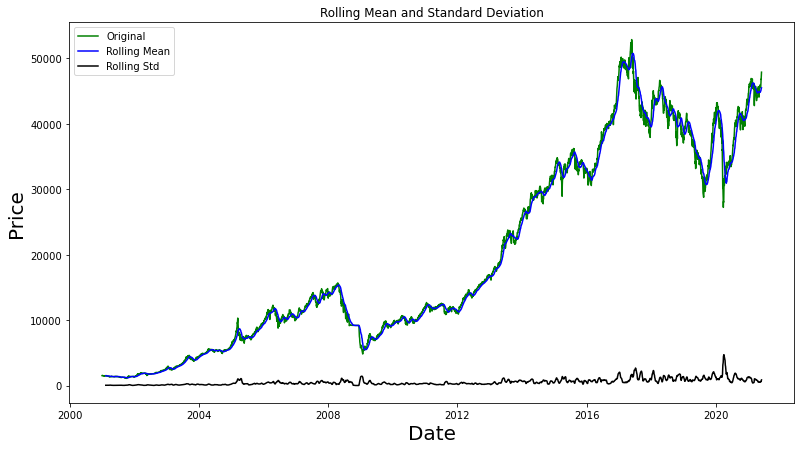

In [34]:
rolling_mean_std(close) # Plot it to visualize the stationarity of data.

#### As we can see the rolling mean and std are not constant. Performing Augmented dickey fuller test

In [11]:
def dickey_test(close_price):
    #dickey fuller test
    adft = adfuller(close_price) # Test for checking trends and seasonality in data
    output = pd.Series(adft[1],index=['p-value']) # Forming the output
    print(output)

dickey_test(close)

p-value    0.943384
dtype: float64


#### As p-value > 0.05 so the series is not stationary it has trend and seasonality.

### In order to create a stationary process, differencing may be necessary. 

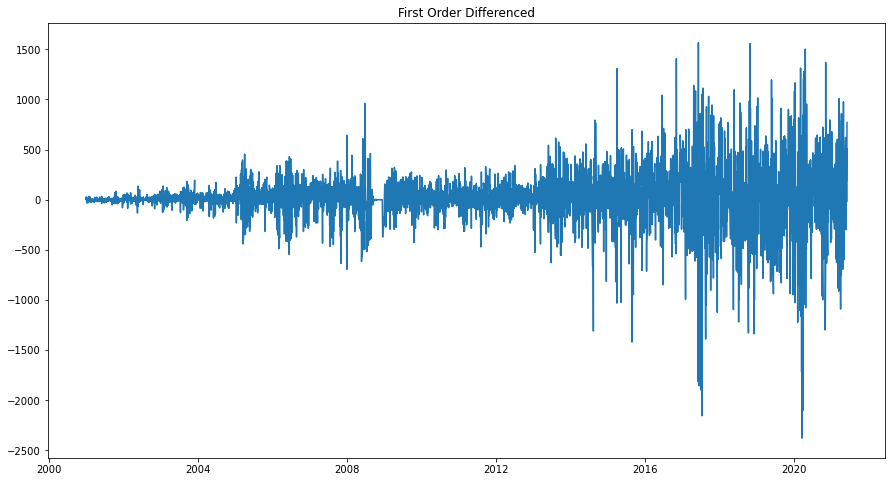

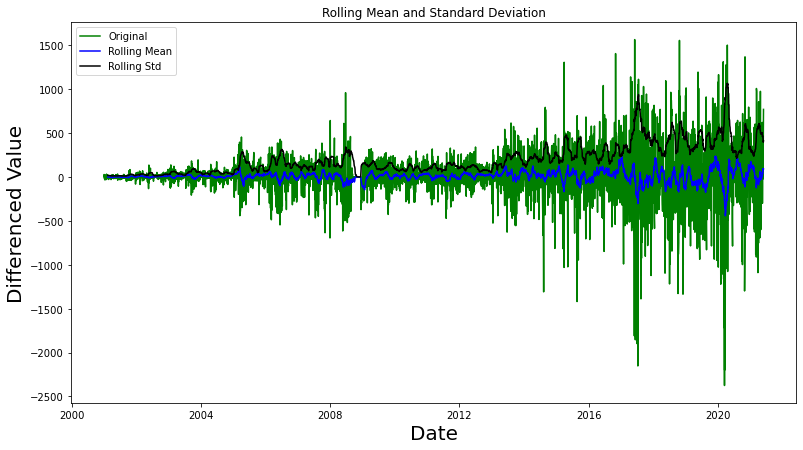

In [37]:
first_order_difference = first_diff(close) # plot to see if the data goes around a constant mean
rolling_mean_std(first_order_difference) # Checking rolling mean and std of first order differenced data

In [15]:
dickey_test(first_order_difference) # Checking p-value of test if less than 0.05

p-value    0.0
dtype: float64


### As p value is extremely small the series is more likely to stationary

<Figure size 432x288 with 0 Axes>

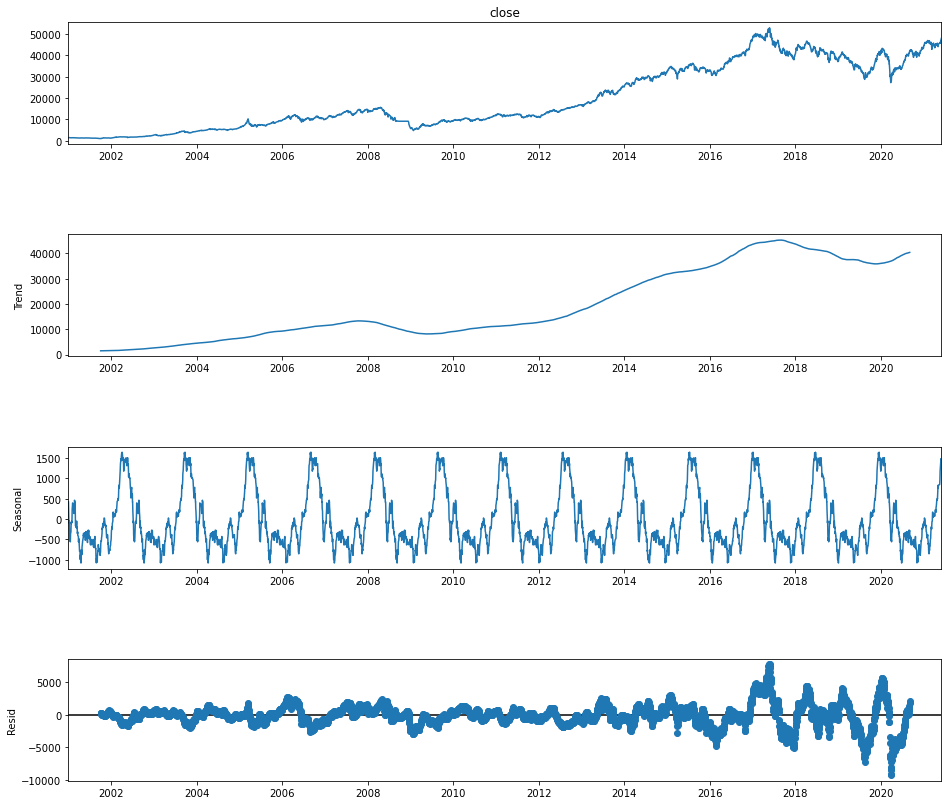

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose # seasonally  decomposing the data 

result = seasonal_decompose(close.dropna(), freq=365) # 

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 13)

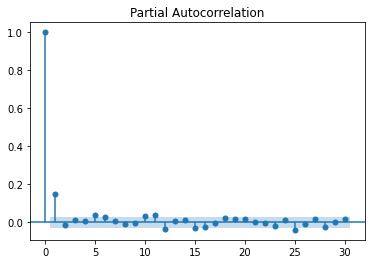

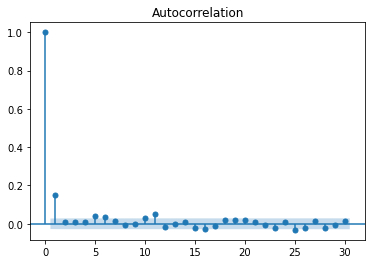

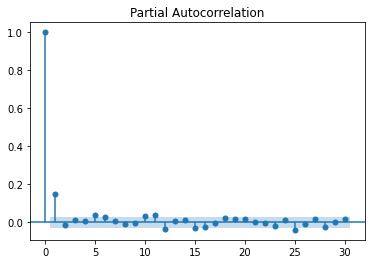

In [17]:
plot_acf(first_order_difference, lags=30) # ACF Plot
plot_pacf(first_order_difference, lags=30) # PACF Plot

In [18]:
#Fucntion to evaluate the order of arima model parameteres
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.90) # 80% for training and 20% for testing
    train, test = X[0:train_size], X[train_size:] # Train and test data
    history = [x for x in train] # Training set list
    # make predictions
    predictions = list()
    aic = float("inf")
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order) # Order of ARIMA 
        
        model_fit = model.fit(disp=0) # Show convergence inf
        yhat = model_fit.forecast()[0] # Predict the value
        if aic > model_fit.aic:
            aic = model_fit.aic
        predictions.append(yhat) # Append it to predicted 
        
        history.append(test[t]) # Append the test value
        print('predicted=%f, expected=%f' % (yhat, test[t]))
        
    error = mean_squared_error(test, predictions) # Calculate mean square error
    
    return error,aic  
######################################
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32') # To get more significant digits in the dataset values
    
    best_score, best_cfg = float("inf"), None # Initialize best Score with infinite and Best Configuration = None
    
    train_size = int(len(close) * 0.90) # 90% for training and 10% for testing
    
    train, test = close[0:train_size], close[train_size:] # Train and test data
    for p in p_values: # AR terms 
        
        for d in d_values: # Order of differencing
        
            for q in q_values: # MA terms ( Error terms )
                
                order = (p,d,q) # Current evaluaing order
                
                print("Evaluating Order:",order)
                
                try:
                    mse,aic = evaluate_arima_model(dataset, order) #Mean square error
                    
                    ###########################
                    # Writing MSE and AIC to text file
                    with open('weights_Final.txt', 'a') as f:
                        line = "MSE: "+str(mse)+" Aic: "+str(aic)+" ORDER: "+str(order)+"\n"
                        f.write(line)
                        
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score)) # print the best MSE
#####################################################
aic_list = []
def eva_aic(X,p_values,d_values,q_values):
    for p in p_values: # AR terms 
        for d in d_values:# Order of differencing
            for q in q_values: # MA terms ( Error terms 
                order = (p,d,q) # Current evaluaing order
                print(order)
                try:
                    model = ARIMA(X, order)
                    model_fit = model.fit(disp=0)
                    print("Order: ",str(order)," Aic: ",str(model_fit.aic))
                    aic_list.append(model_fit.aic)
                    with open('aic_f.txt', 'a') as f:
                        line = "Aic: "+str(model_fit.aic)+" ORDER: "+str(order)+"\n"
                        f.write(line)
                        print(line)
#                     return model_fit.aic
                    # plot residual errors

                except Exception as e:
                    print(e)
                    continue

Now we will Train and Predict the chosen order for ARIMA model.

In [19]:
# Trainig the model
size = int(len(close) * 0.90) # size f
train, test = close[0:size], close[size:len(close)]
history = [x for x in train]
predictions = list()
# Train after each test 
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1)) # Fit model at each iteration
    model_fit = model.fit(disp=0) # Set display information to zero
    output = model_fit.forecast() # Forecast 
    yhat = output[0] # One day ahead
    predictions.append(yhat) # Append Y^ to prediction list
    obs = test[t] # Get the current value being tested 
    history.append(obs) # Append it to training
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=34696.212975, expected=33900.380000
predicted=33775.498545, expected=33885.090000
predicted=33904.574294, expected=34291.650000
predicted=34362.748770, expected=33971.120000
predicted=33916.407329, expected=33166.620000
predicted=33048.362674, expected=33250.540000
predicted=33287.364580, expected=33442.100000
predicted=33475.205614, expected=34637.140000
predicted=34836.981266, expected=35581.340000
predicted=35720.929993, expected=35703.810000
predicted=35713.214608, expected=35697.370000
predicted=35702.280939, expected=34949.280000
predicted=34829.430136, expected=35959.430000
predicted=36148.929543, expected=35974.790000
predicted=35960.453260, expected=35505.290000
predicted=35437.608977, expected=34567.550000
predicted=34427.875643, expected=34659.850000
predicted=34701.114415, expected=34937.930000
predicted=34985.275083, expected=35403.070000
predicted=35480.983388, expected=35572.950000
predicted=35597.725972, expected=35168.820000
predicted=35105.444779, expected=3

predicted=40222.571427, expected=40884.250000
predicted=40996.947536, expected=40724.410000
predicted=40690.700368, expected=40143.630000
predicted=40063.538110, expected=39296.700000
predicted=39178.810042, expected=39714.460000
predicted=39807.735212, expected=40531.130000
predicted=40656.779713, expected=40455.440000
predicted=40430.775367, expected=40243.260000
predicted=40221.227884, expected=40276.930000
predicted=40294.328271, expected=40175.350000
predicted=40164.181568, expected=40574.520000
predicted=40649.366753, expected=40481.650000
predicted=40462.468428, expected=40249.220000
predicted=40223.070611, expected=39143.730000
predicted=38976.056124, expected=38858.450000
predicted=38847.189878, expected=38338.330000
predicted=38262.982425, expected=38087.320000
predicted=38065.454627, expected=37983.620000
predicted=37977.600756, expected=39296.300000
predicted=39519.719634, expected=39199.680000
predicted=39157.675645, expected=38906.400000
predicted=38873.677966, expected=3

predicted=41140.363058, expected=41266.000000
predicted=41291.755667, expected=41850.470000
predicted=41951.396622, expected=41381.830000
predicted=41300.208381, expected=41186.860000
predicted=41173.169933, expected=39888.000000
predicted=39683.562619, expected=39112.180000
predicted=39013.207836, expected=40480.880000
predicted=40726.733416, expected=40281.960000
predicted=40222.101621, expected=41071.300000
predicted=41212.333553, expected=40731.610000
predicted=40669.324013, expected=40784.040000
predicted=40806.824089, expected=41153.050000
predicted=41217.036624, expected=41197.320000
predicted=41204.801452, expected=40564.550000
predicted=40470.272233, expected=40569.350000
predicted=40588.916019, expected=40504.750000
predicted=40499.766347, expected=40652.670000
predicted=40684.462106, expected=40514.670000
predicted=40496.569878, expected=40540.700000
predicted=40554.555149, expected=40187.180000
predicted=40136.801378, expected=39632.520000
predicted=39557.137771, expected=3

In [20]:
#Make Data fram of prediction list with date as index
predictions_df = pd.DataFrame(predictions,columns=['Predictions'],index=test.index) 

In [21]:
# MEAN ABOSULTE PERCENTAGE ERROR
mape = np.mean(np.abs(predictions - test.values)/np.abs(test.values))
print(f"The model is about {round((1-mape)*100)} % accurate in predicting the next {len(predictions)} observations.")

The model is about 84 % accurate in predicting the next 505 observations.


### The model is about 84 % accurate in predicting the next 505 observations.

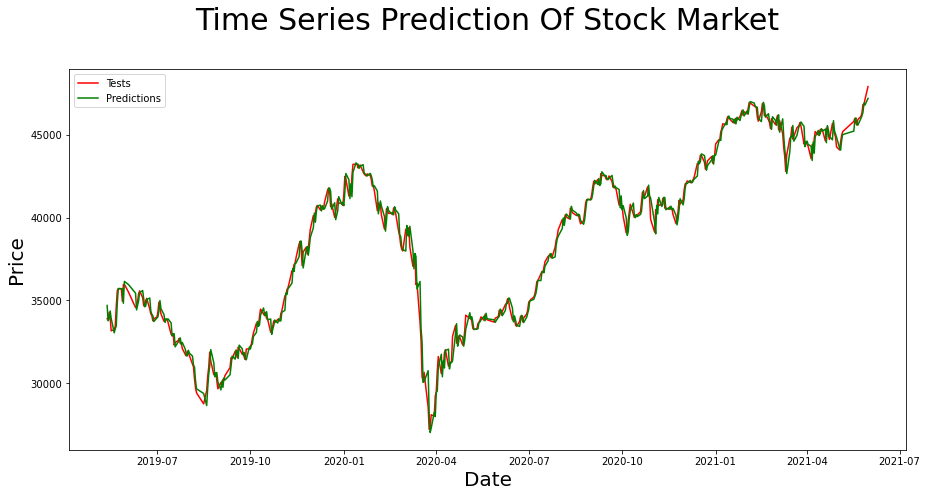

In [38]:
plt.figure(figsize=(15,7))
plt.title("Time Series Prediction Of Stock Market\n",fontsize=30)
plt.plot(test, color='red',label='Tests')   # Test values
plt.plot(predictions_df, color='green', label='Predictions') # predicted by model
plt.xlabel("Date",size=20)
plt.ylabel("Price",size=20)
plt.legend(loc='best') #An area specifying the element

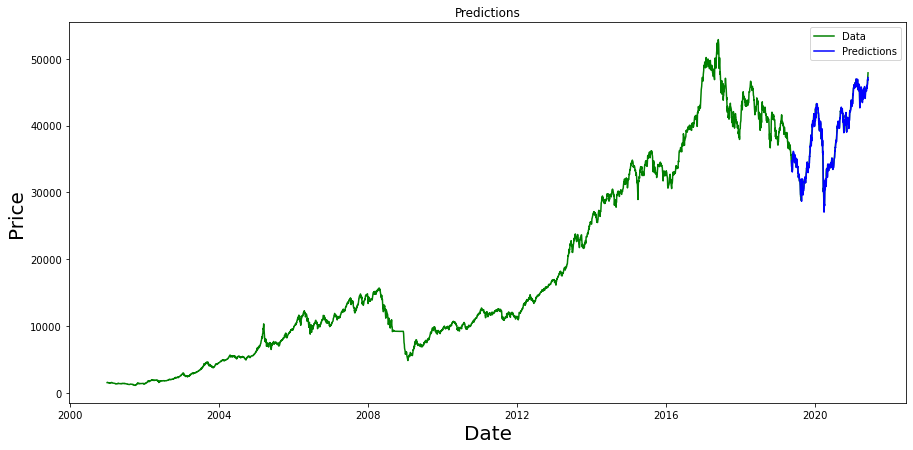

In [40]:
plt.figure(figsize=(15,7))
plt.plot(close, color='green',label='Data')  # Actual Data
plt.plot(predictions_df, color='blue', label='Predictions') # Predictions
plt.title('Predictions') # Title 
plt.xlabel("Date",size=20)
plt.ylabel("Price",size=20)
plt.legend(loc='best') #An area specifying the element

In [24]:
def predict_next(history):
    future_days = int(input("Enter the number of days to be predicted:"))

    datelist = pd.date_range(close.index[-1], periods=future_days,freq='B')# create date range from last date in data
    
    datelist_2 = datelist.date.tolist()
    
    model = ARIMA(close, order=(1,1,1)) #train model

    model_fit = model.fit() #Fit model 

    output = model_fit.forecast(steps=future_days)[0] #Getting Predictions for future 
    
    mondays , tuesdays , wednesdays, thursdays, fridays, monday_max = avg_change() # avg c
    ###### Output the predictions
    print("Average Change in KSE-100 Index Points on Mondays: ",mondays)
    print("Average Change in KSE-100 Index Points on Tuesdays: ",tuesdays)
    print("Average Change in KSE-100 Index Points on Wednesdays: ",wednesdays)
    print("Average Change in KSE-100 Index Points on Thursdays: ",thursdays)
    print("Average Change in KSE-100 Index Points on Fridays: ",fridays)
    print("KSE-100 Index Now: ",close.values[-1])
    
    print(f'\nPredictions of next {future_days} days\n')
    
    print("\nMonday has negative change in index points with an average of", mondays, "and worst change is: ",monday_max)
    print("Monday is best to Purchase stocks.")
    print("Friday is best to Sell stocks.")
    print("KSE-100 Performs Best on Wednesday!\n")
    for i in range(len(output)):
        if datelist[i].day_name() == "Monday":
            print('\n')
            print(datelist_2[i],datelist[i].day_name(),':',round(output[i],2))
            print("Modified prediction based on Average change is: ", round(output[i],2) + mondays,'\n')
        else:
            print(datelist_2[i],datelist[i].day_name(),':',round(output[i],2))

In [29]:
warnings.filterwarnings("ignore")
def avg_change():
    #Getting latest date from previous dataset
    data = pd.read_csv("./indexData/KSE-100-Latest.csv") # Read Data set

    data['date'] = pd.to_datetime(data.date) #Convert date index to proper format

    data.set_index('date', inplace=True) #Set date column as index
    data = data.replace(',','', regex=True).astype(float)
    change = data['change'] # Get close price from data set
    change = change.sort_index(ascending=True) #Sort from oldest to latest

    # Getting average change on each week day and rounding them to 0
    mondays = round(change[change.index.weekday==0].values.mean(),2)
    monday_max = round(change[change.index.weekday==0].values.min(),2)
    tuesdays = round(change[change.index.weekday==1].values.mean(),2)
    wednesdays = round(change[change.index.weekday==2].values.mean(),2)
    thursdays = round(change[change.index.weekday==3].values.mean(),2)
    fridays = round(change[change.index.weekday==4].values.mean(),2)
    
    return mondays,tuesdays,wednesdays,thursdays,fridays,monday_max

In [30]:
predict_next(close)

Enter the number of days to be predicted:10
Average Change in KSE-100 Index Points on Mondays:  -36.08
Average Change in KSE-100 Index Points on Tuesdays:  18.64
Average Change in KSE-100 Index Points on Wednesdays:  29.34
Average Change in KSE-100 Index Points on Thursdays:  13.25
Average Change in KSE-100 Index Points on Fridays:  21.93
KSE-100 Index Now:  47896.34

Predictions of next 10 days


Monday has negative change in index points with an average of -36.08 and worst change is:  -2375.97
Monday is best to Purchase stocks.
Friday is best to Sell stocks.
KSE-100 Performs Best on Wednesday!



2021-05-31 Monday : 48014.15
Modified prediction based on Average change is:  47978.07 

2021-06-01 Tuesday : 48027.33
2021-06-02 Wednesday : 48036.67
2021-06-03 Thursday : 48045.87
2021-06-04 Friday : 48055.07


2021-06-07 Monday : 48064.27
Modified prediction based on Average change is:  48028.189999999995 

2021-06-08 Tuesday : 48073.46
2021-06-09 Wednesday : 48082.66
2021-06-10 Thursday 

###############################################################
### Ŷt = constant + Yt-1 + ϕ1 (Yt-1 - Yt-2 ) - θ1et-1
### 9.04572889 + 47896.34 + ( 680 * 0.0382) - (0.1114* (711))
### 9.04572889 + 47896.34 + 25.976 - 79.20
### Yt = 47852.16172889